<a href="https://colab.research.google.com/github/mikeboyle321/Macromolecular_Engineering_Nanoparticle_Transport/blob/main/Worked_Example_DLVO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extended DLVO - colloid interactions with a substrate in electrolyte solutions.

This notebook walks through the analysis of a PS Nanoparticle Interacting with a silica substrate as a function of distance from the substrate using an extended DLVO model adapted from 

Handol Lee, Doris Segets, Sebastian Süß, Wolfgang Peukert, Sheng-Chieh Chen, David Y.H. Pui,
Liquid filtration of nanoparticles through track-etched membrane filters under unfavorable and different ionic strength conditions: Experiments and modeling,
Journal of Membrane Science,
Volume 524,
2017,
Pages 682-690,
ISSN 0376-7388,
https://doi.org/10.1016/j.memsci.2016.11.023.
(https://www.sciencedirect.com/science/article/pii/S0376738816312352)


In [2]:
# Import key python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from ipywidgets import interactive, IntSlider, RadioButtons, FloatText, IntText
# set font size for plots globally
plt.rcParams.update({'font.size': 14})

## First we need to define some key constants

In [3]:
kb = 1.38064852E-23 # J/K, boltzmann constant
lambda_char = 100*1E-9 # m, 100 nm characteristic retardation wavelength ~ ionization wavelength
e_0 = 8.85418782E-12 # F/m
e_r = 78.4 # relative permittivity of water
e_coulomb = 1.602176634E-19 # C 
T = 298 # K
Na = 6.022E23 #/mol, Avogadro

## Plot the VdW interaction potential for varying separation particle sizes
* Van der Waals interaction constants from Israelachvili, J.N., Intermolecular and Surface Forces, Third Edition 2011


A_eff = 1.0980904698146341e-21 J


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


Text(0, 0.5, '$\\frac{\\phi_{VdW}}{k_{b}T}$')

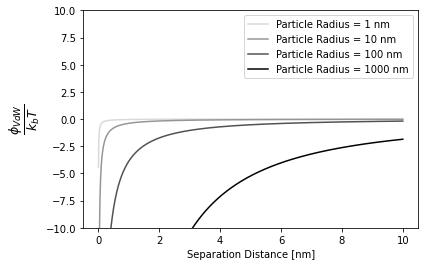

In [22]:
# Define a function for calcuating VdW forces
def calc_vdw(h_min, h_max, r_np_calc, A_vdw, lambda_ion):
  h_calc = np.linspace(h_min, h_max, 1000)*1E-9 # m
  r_calc = r_np_calc*1E-9 # converts nm to m
  phi_vdw_calc = (-A_vdw*r_calc*(1 + 14*h_calc/lambda_ion)**(-1))/(6*h_calc) # J
  return h_calc, phi_vdw_calc # returns m, J

# Use combination rule to estimate Hamaker Constant, A_eff
A_ps = np.mean([6.6E-20, 7.9E-20])  # J
A_h2o = np.mean([3.7E-20, 5.5E-20]) # J
A_sio2 = np.mean([5E-20, 6E-20]) # J
A_eff = (np.sqrt(A_ps) - np.sqrt(A_h2o))*(np.sqrt(A_sio2) - np.sqrt(A_h2o)) # J
print(f'A_eff = {A_eff} J')

# define constants
r_np = [1,10,100, 1000] #test  differnt parictle diameters, nm
sep_min = 0 # nm
sep_max = 10 # nm
kT = kb*T
for i, value in enumerate(r_np):
  h, phi_vdw = calc_vdw(h_min = sep_min, h_max = sep_max, r_np_calc = value, A_vdw=A_eff, lambda_ion = lambda_char)
  plt.plot(h*1E9, phi_vdw/kT, color =  plt.cm.Greys((1/len(r_np))*(i+1)), label = ('Particle Radius = ' + str(value) + ' nm'))
  plt.legend()
plt.ylim([-10,10])
plt.xlabel('Separation Distance [nm]')
plt.ylabel(r'$\frac{\phi_{VdW}}{k_{b}T}$', fontsize=18)

# Plot the Electric Double Layer ion concentration profile for varying salt concentration

Debye Length for [NaCl]=0.001 M is 13.592562074737513 nm
Debye Length for [NaCl]=0.01 M is 4.29834553933944 nm
Debye Length for [NaCl]=0.1 M is 1.3592562074737513 nm
Debye Length for [NaCl]=1 M is 0.429834553933944 nm


Text(0, 0.5, '$\\frac{\\phi_{EDL}}{k_{b}T}$')

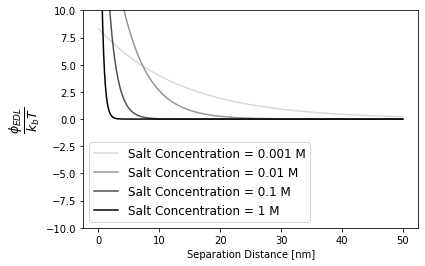

In [21]:
# Define a function for calcuating EDL forces
def calc_edl(h_min, h_max, r_np_calc, c_s_bulk_calc, z_ion_calc, psi_p_calc, psi_s_calc):
  h_calc = np.linspace(h_min, h_max, 1000)*1E-9 # m
  r_calc = r_np_calc*1E-9 # converts nm to m
  debye_param_calc = np.sqrt((1000*c_s_bulk_calc*Na*e_coulomb**2*z_ion_calc**2)/(e_0*e_r*kb*T)) # m^-1
  phi_edl_calc = (((64*np.pi*e_r*e_0)/debye_param_calc)*
                  (kb*T/(z_ion_calc*e_coulomb))**2*
                  np.tanh(z_ion_calc*e_coulomb*psi_s_calc/(4*kb*T))*
                  np.tanh(z_ion_calc*e_coulomb*psi_p_calc/(4*kb*T))*
                  ((debye_param_calc*r_calc - 1)*np.exp(-debye_param_calc*h_calc) + (debye_param_calc*r_calc + 1)*np.exp(-debye_param_calc*(h_calc+2*r_calc)))
                  )
  print(f'Debye Length for [NaCl]={c_s_bulk_calc} M is {1/debye_param_calc*1E9} nm')
  return h_calc, phi_edl_calc # returns m, J

r_np = 10 # nm
psi_s = -50*1E-3 # V
psi_p = -50*1E-3 # V
z = 1 # salt valency - 1 for monovalent salt like NaCl
c_salt = [0.001, 0.01, 0.1, 1] # concentration of salt in the bulk soltuion in mol/L
kT = kb*T
# define constants
sep_min = 0 # nm
sep_max = 50 # nm
kT = kb*T
for i, value in enumerate(c_salt):
  h, phi_edl = calc_edl(h_min=sep_min, h_max=sep_max, r_np_calc=r_np, c_s_bulk_calc=value, z_ion_calc=z, psi_p_calc=psi_p, psi_s_calc=psi_s)
  plt.plot(h*1E9, phi_edl/kT, color =  plt.cm.Greys((1/len(c_salt))*(i+1)), label = ('Salt Concentration = ' + str(value) + ' M'))
plt.legend(fontsize=12)
plt.ylim([-10,10])
# plt.title('EDL for 100 nm PS particle in NaCl')
plt.xlabel('Separation Distance [nm]')
plt.ylabel(r'$\frac{\phi_{EDL}}{k_{b}T}$', fontsize=18)

## VdW Interaction potentials have a minimum at -inf as the separation between particle and substrate approaches 0. This is clearly non-physical. In real experiments (ignoring molecular complications of the continuum assumption breakdown), repulsive forces (solvation, steric hidrances (i.e.) polymers) increase the interaction potential as a particle approceas the surface. To account for this, Lee .et *al* model short range repulsion (Pauli exclusion) from overlapping molecular orbitals via a Born Repulsion term with a potential shown below.

In [32]:
def calc_born_rep()


4.6513333333333335

# Interactively plot the competition between all of them, with option to change any parameters

In [ ]:
# define constants
a = [1,10,100] # differnt parictle diameters,  nm
h = np.linspace(0.001, 10) # separation distance range in nm
kT = kb*T
for i in a:
  phi_vdw = (-A_eff*i*(1 + 14*h/lambda_char)**(-1))/(6*h)
  plt.plot(h, phi_vdw/kT, label = ('Particle Radius = ' + str(i) + ' nm'))
  plt.legend()
plt.ylim([-3,3])
plt.xlabel('Separation Distance [nm]')
plt.ylabel(r'$\frac{\phi_{VdW}}{k_{b}T}$')